# Using Machine Learning for the Differential Diagnosis of Movement Disorders

Marta M. Correia

November 2023

## Introduction
The dataset used in this project has been described in Correia et al., 2020 (doi:10.1093/braincomms/fcaa051). It includes data from 134 healthy controls (C) and patients with one of threes diagnoses: Parkinson's disease (PD), Progressive Supranuclear Palsy (PSP) and Corticobasal Degeneration (CBD). For each participant, 200 features were extracted from diffusion MRI data, covering 100 different white-matter ROIs and two different metrics: Mean Diffusivity (MD) and Fractional Anisotropy (FA). As described in Correia et al., 2020, the data has been split into a testing set including 19  well-matched participants for each class (C, CBD, PD and PSP), and a testing dataset consisting of the remaining 58 participants.  
The goal of this project is to compare different normalisation/standardisation methods, as well as different statistical classifiers, for the differential diagnosis of the movement disorders included in this sample.


First, import the required libraries:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

from tabulate import tabulate

Next, load the training datasets with `pandas`:

In [2]:
#load the training data for each patient type

df_C = pd.read_csv('data/C_FA+MD_ROIs.csv')
df_CBD = pd.read_csv('data/CBD_FA+MD_ROIs.csv')
df_PD = pd.read_csv('data/PD_FA+MD_ROIs.csv')
df_PSP = pd.read_csv('data/PSP_FA+MD_ROIs.csv')

#merge into a single dataframe and reset the index
df_all = pd.concat([df_C, df_CBD, df_PD, df_PSP])
df_all.reset_index(drop=True, inplace=True)
df_all.head()

,class,ROI FA 1,ROI FA 2,ROI FA 3,ROI FA 4,ROI FA 5,ROI FA 6,ROI FA 7,ROI FA 8,ROI FA 9,...,ROI MD 91,ROI MD 92,ROI MD 93,ROI MD 94,ROI MD 95,ROI MD 96,ROI MD 97,ROI MD 98,ROI MD 99,ROI MD 100
0,C,0.48096,0.27942,0.46590,0.56394,0.64034,0.57356,0.64739,0.51727,0.34082,...,2.5108,2.2109,2.0425,2.0345,2.0329,2.0757,2.0434,2.1473,1.9683,0.75558
1,C,0.52952,0.41303,0.54164,0.58751,0.61447,0.51569,0.62484,0.50400,0.27224,...,2.2702,2.2409,2.2237,2.1511,2.2116,2.1386,2.1729,2.2720,2.0781,1.87610
2,C,0.47352,0.41902,0.52054,0.59565,0.62948,0.52275,0.60147,0.54097,0.29204,...,1.8799,2.0553,2.0928,1.9847,1.9629,2.0674,2.0222,1.9980,2.1253,1.90340
3,C,0.44937,0.40753,0.50005,0.56377,0.60699,0.51971,0.62039,0.53671,0.32038,...,1.9337,1.9936,2.0593,2.1882,2.0448,2.0260,1.9277,2.0556,1.9059,1.79540
4,C,0.49535,0.40518,0.51004,0.57428,0.65829,0.55416,0.64591,0.50611,0.31586,...,1.8453,2.0424,2.0584,2.1546,2.0532,2.1773,2.1982,2.0976,2.0337,1.83440


And now we load the testing data:

In [3]:
#load the testing dataset for each patient type

df_C_test = pd.read_csv('data/C_FA+MD_ROIs_testing.csv')
df_CBD_test = pd.read_csv('data/CBD_FA+MD_ROIs_testing.csv')
df_PD_test = pd.read_csv('data/PD_FA+MD_ROIs_testing.csv')
df_PSP_test = pd.read_csv('data/PSP_FA+MD_ROIs_testing.csv')

#merge into a single dataframe and reset the index
df_all_test = pd.concat([df_C_test, df_CBD_test, df_PD_test, df_PSP_test])
df_all_test.reset_index(drop=True, inplace=True)
df_all_test.head()



,class,ROI FA 1,ROI FA 2,ROI FA 3,ROI FA 4,ROI FA 5,ROI FA 6,ROI FA 7,ROI FA 8,ROI FA 9,...,ROI MD 91,ROI MD 92,ROI MD 93,ROI MD 94,ROI MD 95,ROI MD 96,ROI MD 97,ROI MD 98,ROI MD 99,ROI MD 100
0,C,0.47622,0.44293,0.50151,0.57574,0.60735,0.57948,0.58049,0.49867,0.35502,...,2.1240,2.1633,1.9802,1.9161,2.0034,2.0784,2.1093,2.0828,2.1083,1.89640
1,C,0.40074,0.36611,0.40435,0.53504,0.59020,0.51474,0.56650,0.49875,0.36190,...,2.4767,2.4942,2.2252,2.1730,2.3025,2.2746,2.3469,2.3180,2.0614,2.01900
2,C,0.51366,0.33447,0.54713,0.55383,0.61121,0.46308,0.58070,0.47834,0.29424,...,2.3669,2.2776,2.2303,1.9789,2.1695,2.3207,2.4683,2.5864,2.3148,1.62420
3,C,0.50955,0.49255,0.57628,0.56686,0.64572,0.55436,0.61128,0.51709,0.33933,...,1.8407,1.9671,1.9896,1.9734,1.9750,2.0292,2.1576,2.0044,2.0228,1.71960
4,C,0.54804,0.28745,0.50597,0.61273,0.60967,0.49912,0.64542,0.42249,0.28247,...,2.1714,2.4745,2.2776,2.2101,2.2967,2.3495,2.3386,2.4719,2.3583,0.98295


Quickly check that there are no missing values:

In [4]:
#check for missing values in the training data
df_all.isnull().any().any()

False

In [5]:
#check for missing values in the testing data
df_all_test.isnull().any().any()

False

Use boxplots to visualise the data for each class. The difference in scale between the FA and MD features is clearly visible. FA is a value between 0 and 1, while MD (here in units of $10^{-3}$mm$^2$/s) can take any value greater than zero.

<Figure size 640x480 with 0 Axes>

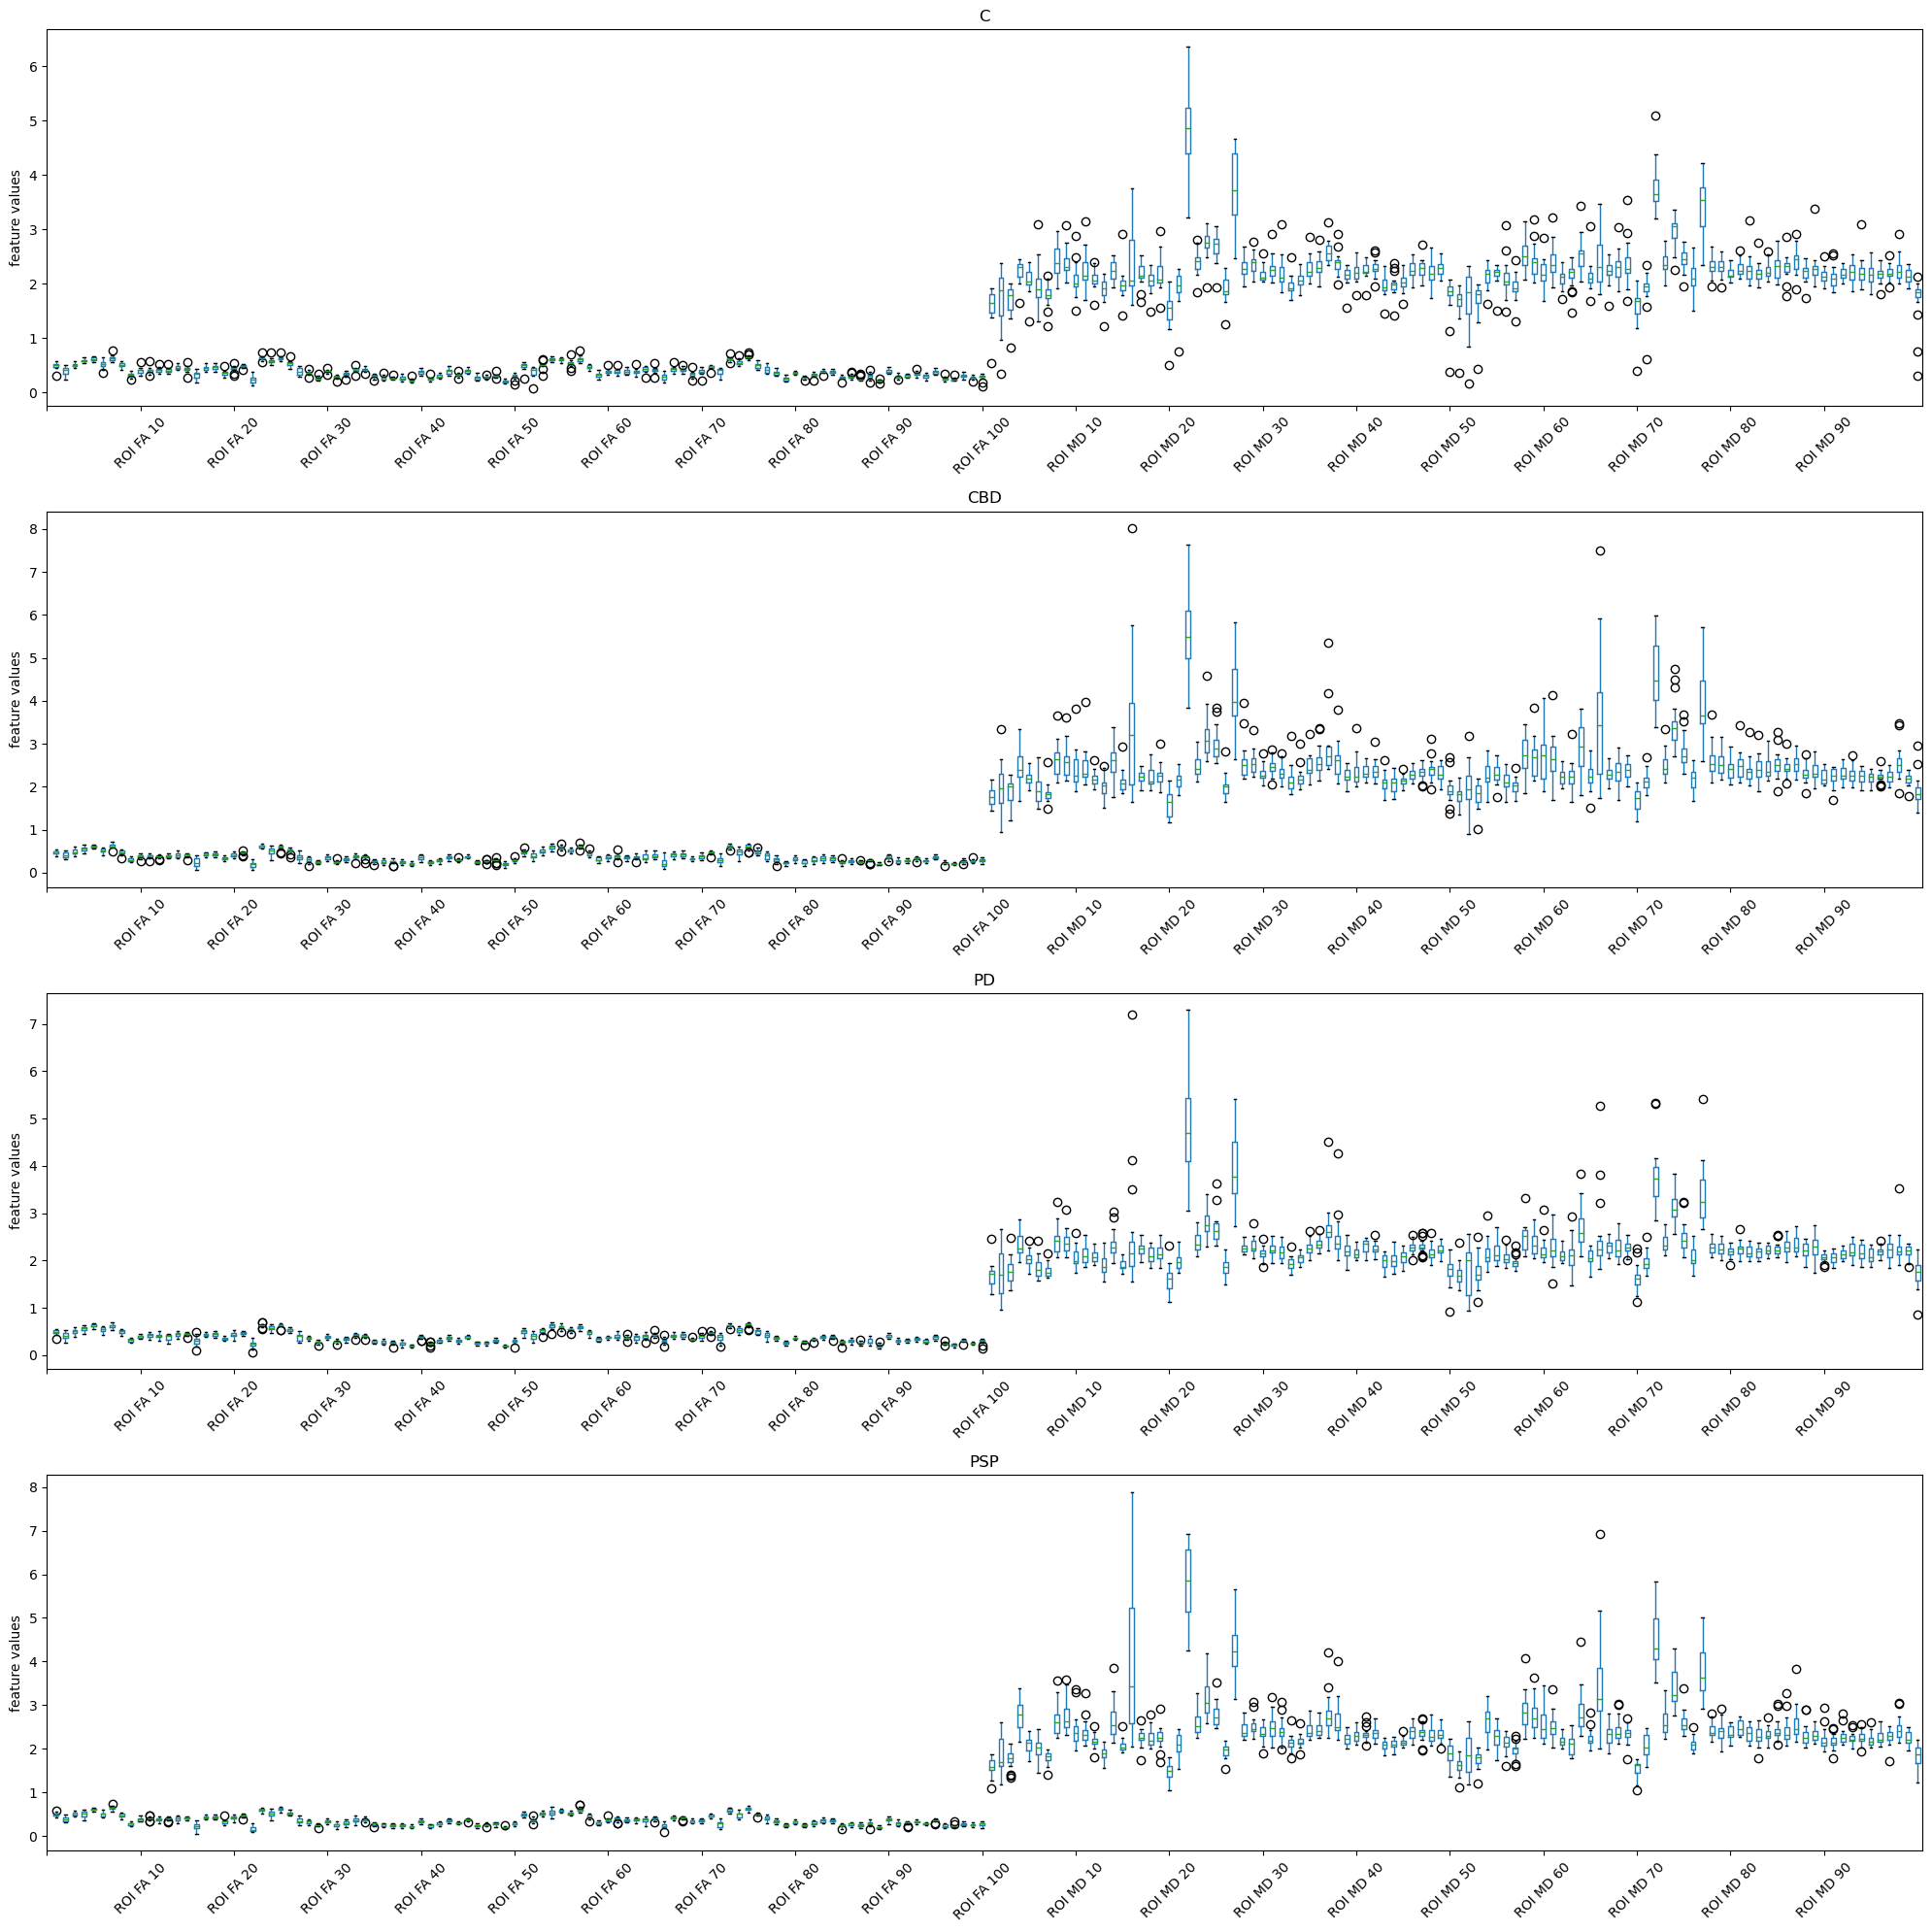

In [6]:
class_labels = df_all['class'].unique()

#create a new figure
plt.figure()

#plot boxplots for all features for each class
fig, fig1 = plt.subplots(nrows=4, ncols=1, figsize=(20,20))

for c, cl in enumerate(class_labels):
    df_all[df_all['class']==cl].boxplot(ax=fig1[c], grid=False, rot=45)
    fig1[c].set_title(cl)
    fig1[c].set_ylabel('feature values')
    fig1[c].set_xticks(range(0, 200, 10));

plt.tight_layout()


Standardise the data using the min-max scaling approach and plot the results. This time I will plot just 10 FA features and 10 MD features to make the figures a little easier to read. The difference in scale between FA and MD features is no longer observed after standardisation. 

<Figure size 640x480 with 0 Axes>

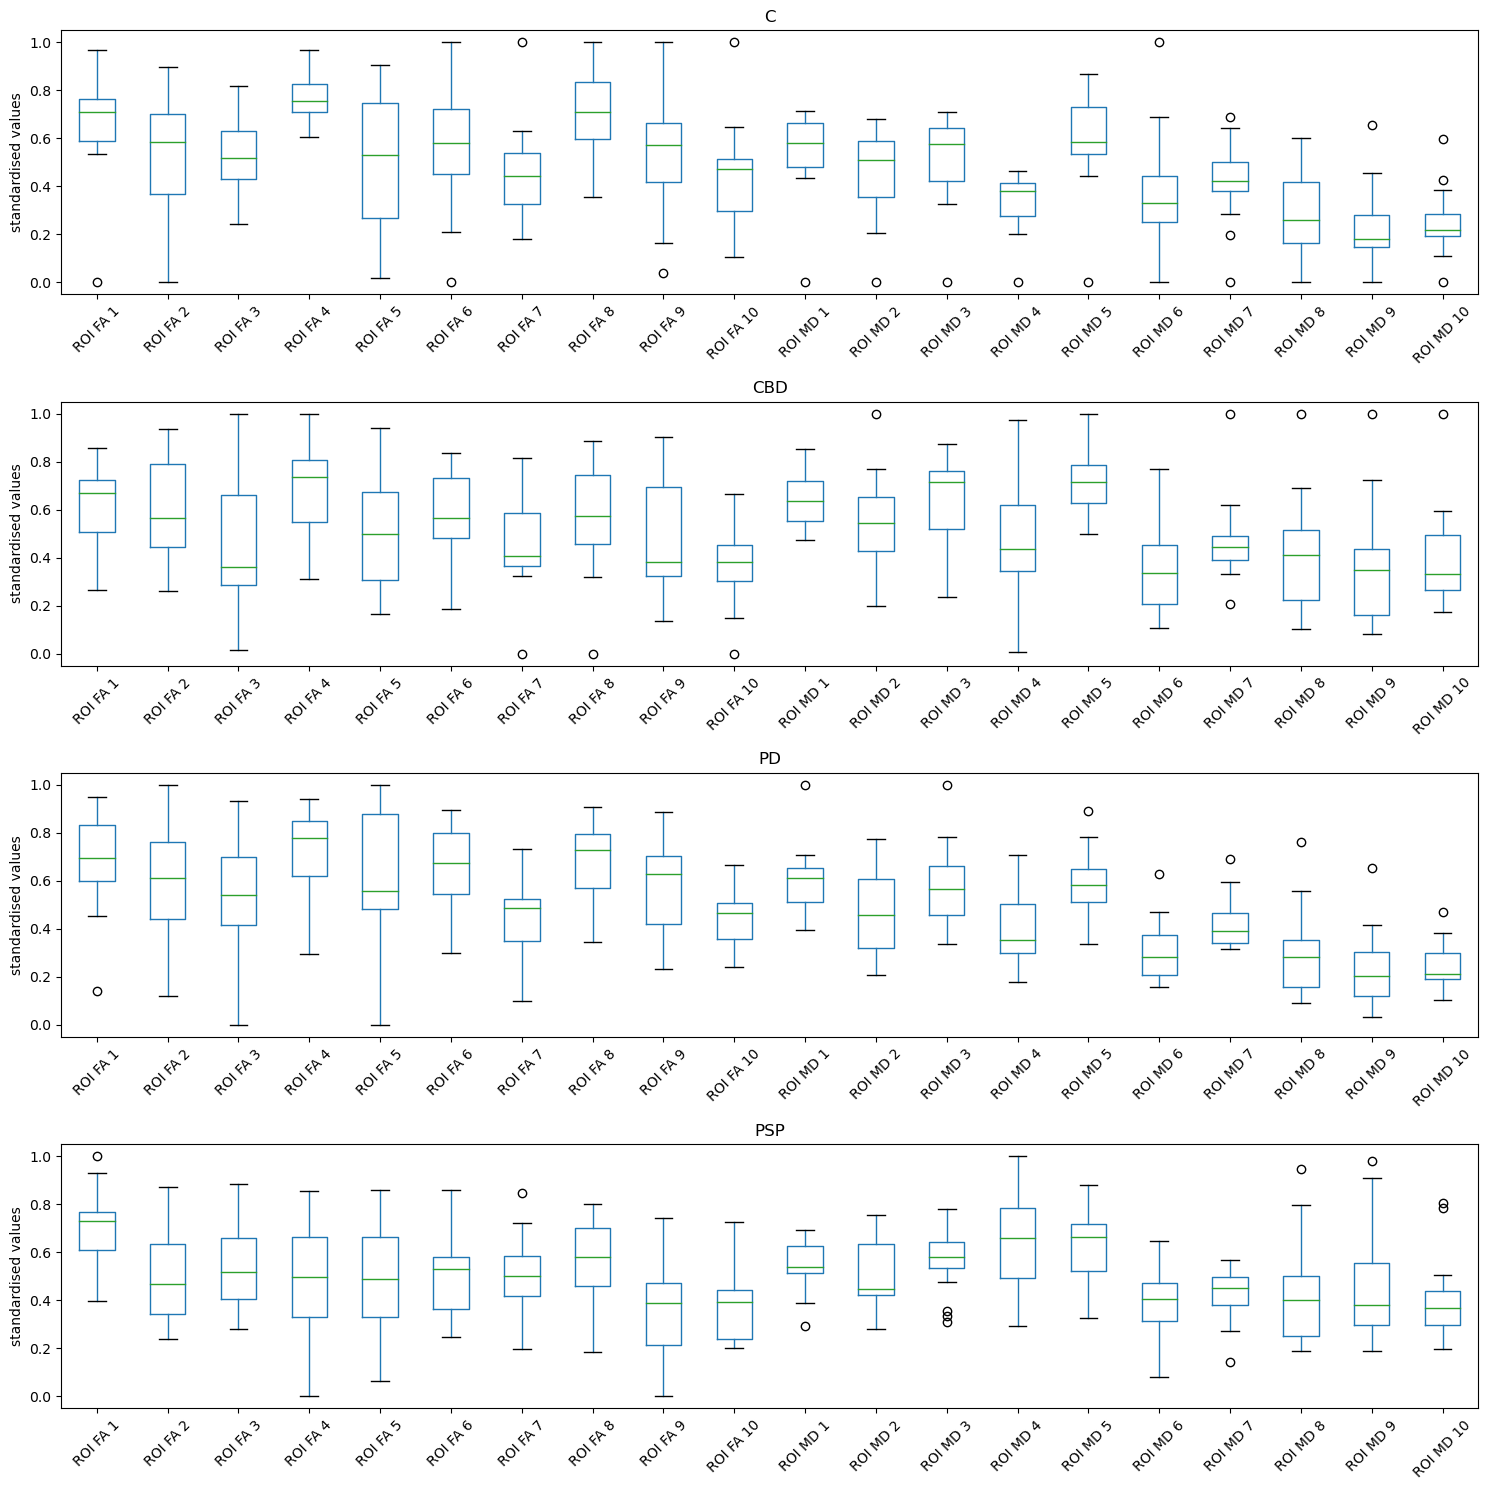

In [7]:
#standardise all features using the min-max formula scaled = (original - min)/(max - min)

df_stand = df_all.copy()

df_cont = df_all.loc[:, df_all.columns != 'class']

df_stand.loc[:, df_stand.columns != 'class']  = ((df_cont)-(df_cont.min()))/((df_cont.max())-(df_cont.min()))


#create a subset of columns to show in the figure
cols_subset = []
#select the first 10 FA features
cols_subset = df_all.columns[1:11]
#select the first 10 MD features
cols_subset = cols_subset.append(df_all.columns[101:111])


#plot boxplots for all standardised features
plt.figure()

#plot boxplots for all features for each class
fig, fig2 = plt.subplots(nrows=4, ncols=1, figsize=(15,15))

for c, cl in enumerate(class_labels):
    df_stand[df_stand['class']==cl][cols_subset].boxplot(ax=fig2[c], grid=False, rot=45)
    fig2[c].set_title(cl)
    fig2[c].set_ylabel('standardised values')
    #fig2[c].set_xticks(range(0, 200, 10));

plt.tight_layout()



Apply standardisation to testing sample, using the min and max values from the training dataset.

In [8]:
df_stand_test = df_all_test.copy()

df_cont_test = df_all_test.loc[:, df_all_test.columns != 'class']

#use the min and max values from the training dataset
df_stand_test.loc[:, df_stand_test.columns != 'class']  = ((df_cont_test)-(df_cont.min()))/((df_cont.max())-(df_cont.min()))


For comparison, apply normalisation (z-scoring) to the training data, and then apply the same normalisation parameters to the testing data. In addition to no difference in scaling between FA and MD features, after normalisation all features are now also centered around zero. 

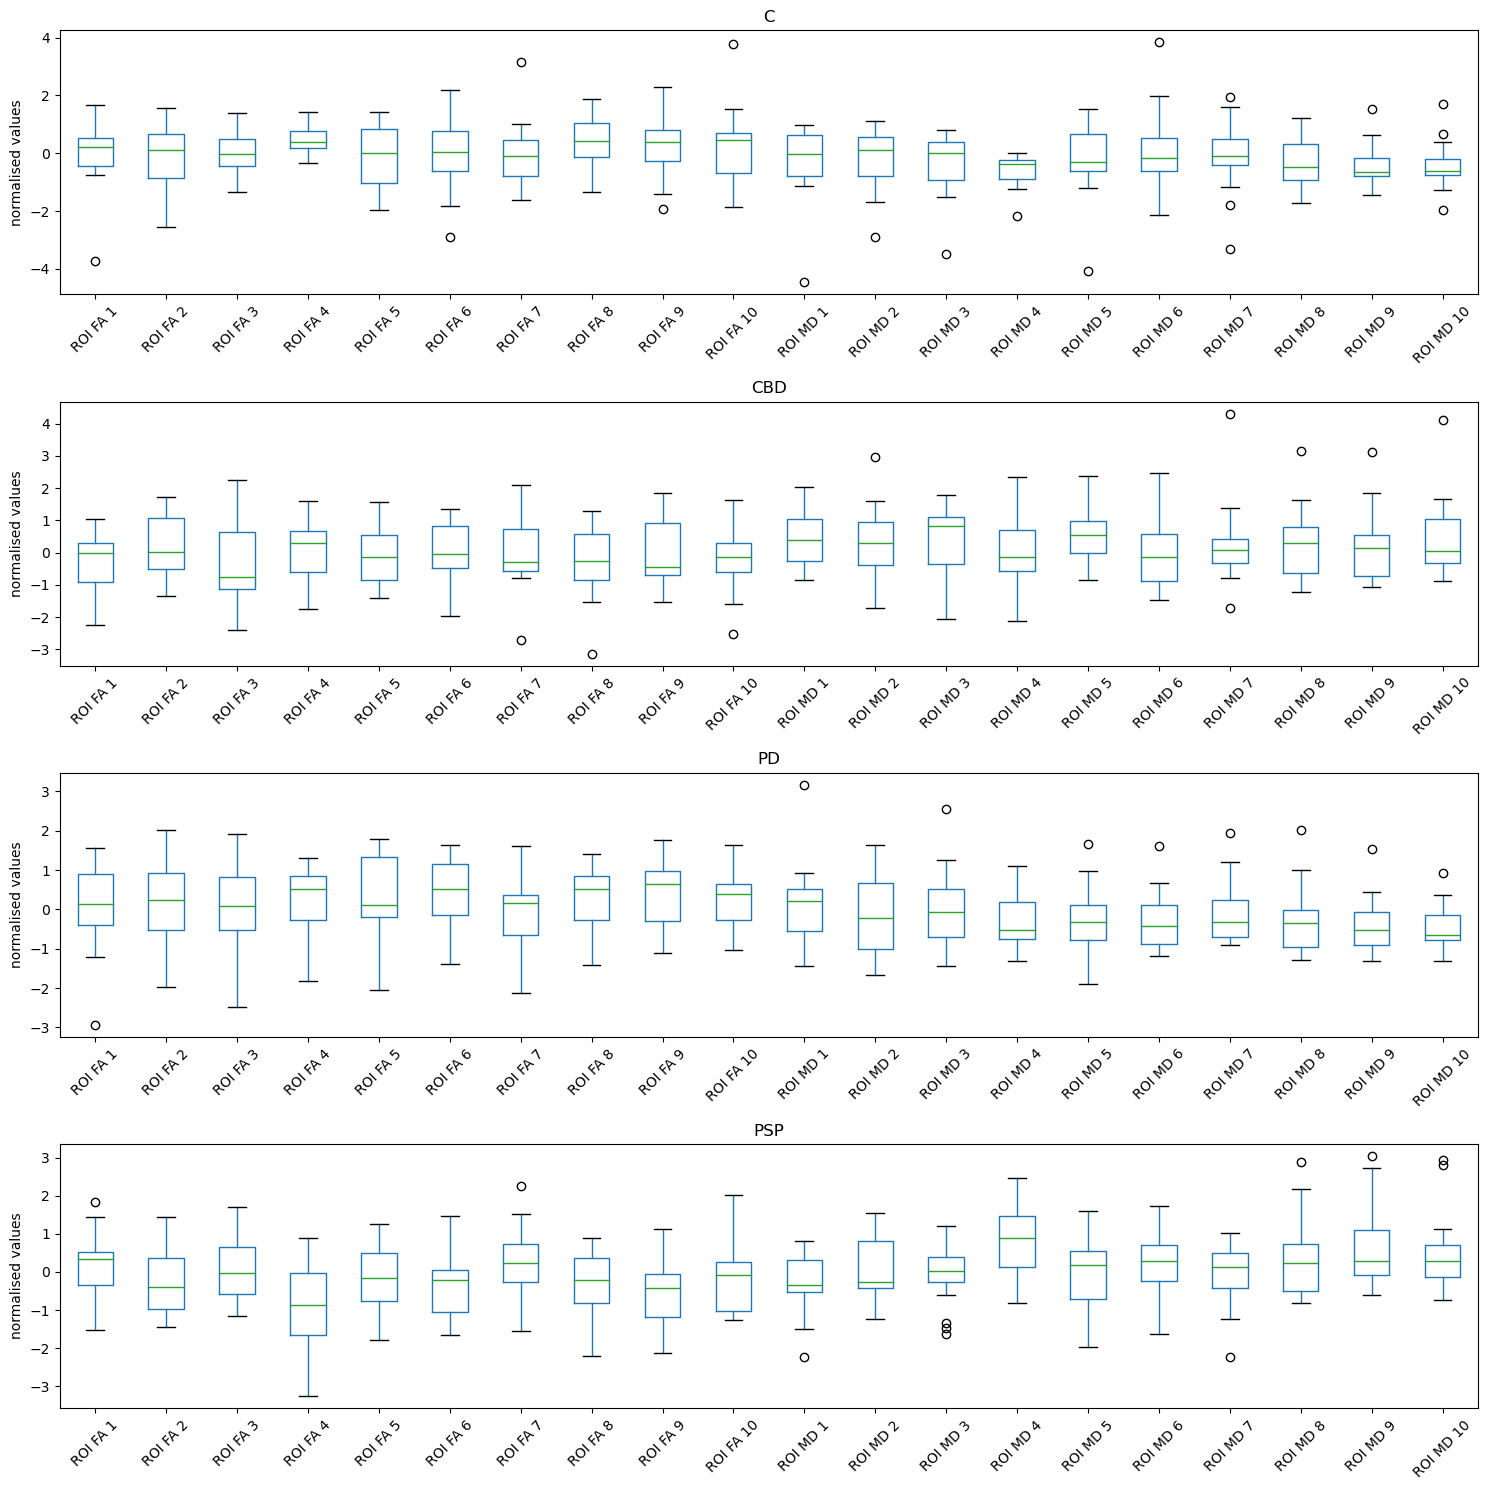

In [9]:
#Apply normalisation to the training data
df_norm = df_all.copy()

df_cont = df_all.loc[:, df_all.columns != 'class']

df_norm.loc[:, df_norm.columns != 'class']  = ((df_cont)-(df_cont.mean()))/(df_cont.std())

#plot boxplots for all features
fig, fig3 = plt.subplots(nrows=4, ncols=1, figsize=(15,15))

for c, cl in enumerate(class_labels):
    df_norm[df_norm['class']==cl][cols_subset].boxplot(ax=fig3[c], grid=False, rot=45)
    fig3[c].set_title(cl)
    fig3[c].set_ylabel('normalised values')
    #fig3[c].set_xticks(range(0, 200, 10));

plt.tight_layout()


#Apply same normalisation to the test data
df_norm_test = df_all_test.copy()
df_cont_test = df_all_test.loc[:, df_all_test.columns != 'class']

#use the mean and std values from the training dataset
df_norm_test.loc[:, df_norm_test.columns != 'class']  = ((df_cont_test)-(df_cont.mean()))/(df_cont.std())


The data is now ready for model fitting. I will fit a logistic regression model as well as support vector machines (SVMs) with two types of kernel, linear and RBF. Model fitting will be performed separately for each pair of control/patient classes. 

In [10]:
#define the pairs of classes 
pairs = [['C','CBD'], ['C','PD'], ['C','PSP'], ['CBD','PD'], ['CBD','PSP'],['PD','PSP']]

columns = ['Model','Preprocessing', 'Pair', 'score']
acc = pd.DataFrame(columns=columns) 

for i, p in enumerate(pairs):
   
    #model fitting for data standardised wint min-max method
    X = df_stand[df_stand['class'].isin([p[0], p[1]])].loc[:, df_stand.columns != 'class']
    y = df_stand[df_stand['class']==p[0]]['class'].tolist() + df_stand[df_stand['class']==p[1]]['class'].tolist()
    
    X_test = df_stand_test[df_stand_test['class'].isin([p[0], p[1]])].loc[:, df_stand_test.columns != 'class']
    y_test = df_stand_test[df_stand_test['class']==p[0]]['class'].tolist() + df_stand_test[df_stand_test['class']==p[1]]['class'].tolist()

    #fit logistic regression
    model = LogisticRegression()
    model.fit(X,y)

    acc.loc[acc.shape[0]]=['LogReg','stand', f'{p[0]}vs{p[1]}', model.score(X_test,y_test)*100]  
    
    #fit linear SVM
    model = svm.SVC(kernel='linear')
    model.fit(X,y)

    acc.loc[acc.shape[0]]=['lSVM','stand', f'{p[0]}vs{p[1]}', model.score(X_test,y_test)*100]  
    
    #fit SVM with RBF kernel
    model = svm.SVC(kernel='rbf')
    model.fit(X,y)

    acc.loc[acc.shape[0]]=['rbfSVM','stand', f'{p[0]}vs{p[1]}', model.score(X_test,y_test)*100]  
    
    #repeat model fitting for normalised data
    X = df_norm[df_norm['class'].isin([p[0], p[1]])].loc[:, df_norm.columns != 'class']
    y = df_norm[df_norm['class']==p[0]]['class'].tolist() + df_norm[df_norm['class']==p[1]]['class'].tolist()
    
    X_test = df_norm_test[df_norm_test['class'].isin([p[0], p[1]])].loc[:, df_norm_test.columns != 'class']
    y_test = df_norm_test[df_norm_test['class']==p[0]]['class'].tolist() + df_norm_test[df_stand_test['class']==p[1]]['class'].tolist()

    #fit logistic regression
    model = LogisticRegression()
    model.fit(X,y)

    acc.loc[acc.shape[0]]=['LogReg','norm', f'{p[0]}vs{p[1]}', model.score(X_test,y_test)*100]  
    
    #fit linear SVM
    model = svm.SVC(kernel='linear')
    model.fit(X,y)
    
    acc.loc[acc.shape[0]]=['lSVM','norm', f'{p[0]}vs{p[1]}', model.score(X_test,y_test)*100]  
    
    #fit SVM with RBF kernel
    model = svm.SVC(kernel='rbf')
    model.fit(X,y)
    
    acc.loc[acc.shape[0]]=['rbfSVM','norm', f'{p[0]}vs{p[1]}', model.score(X_test,y_test)*100]  
    
    

Finally, plot the accuracy results obtained for each pair of controls/patients:

<Figure size 640x480 with 0 Axes>

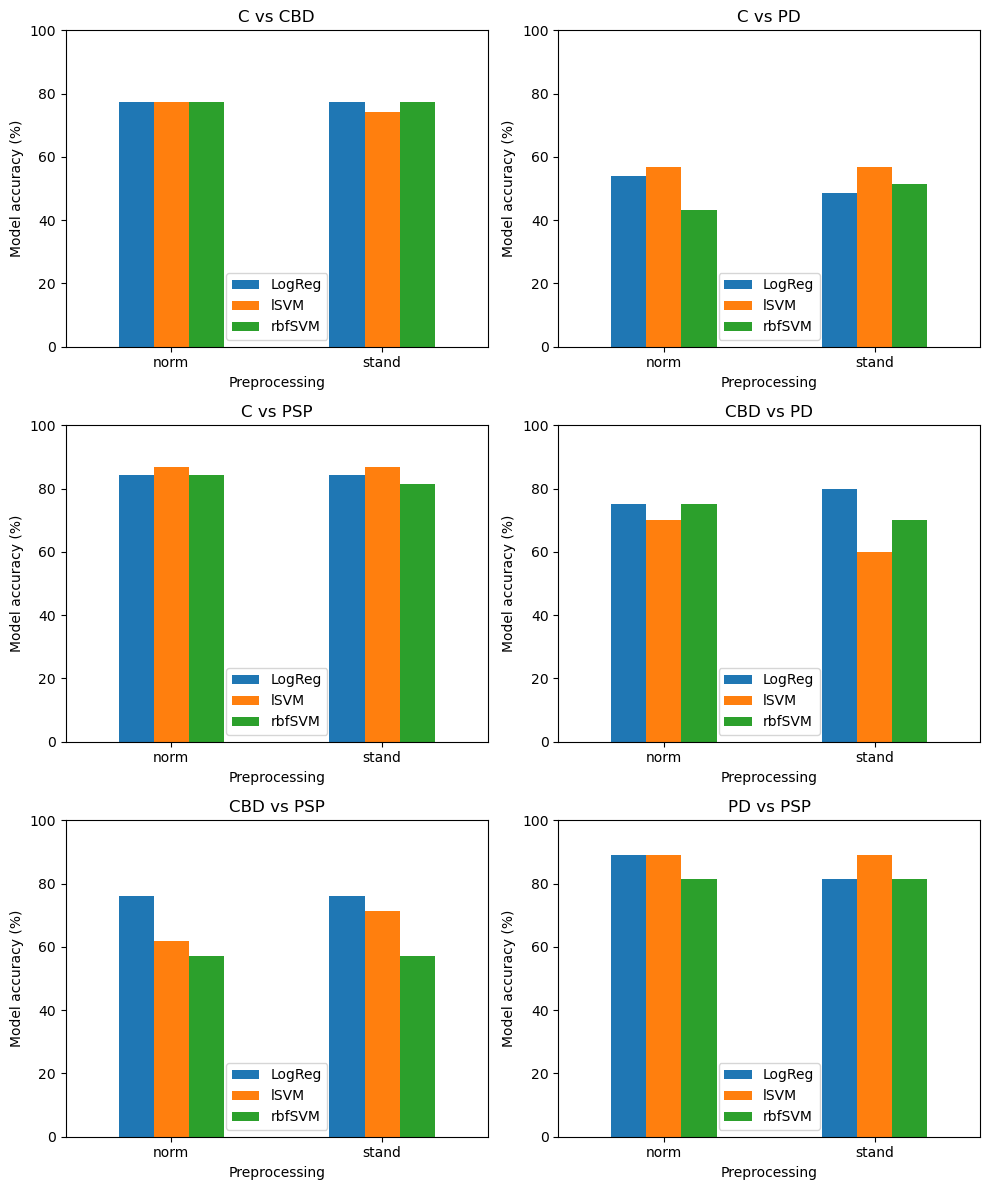

In [11]:
plt.figure()
fig, fig4 = plt.subplots(nrows=3, ncols=2, figsize=(10,12))

for i, p in enumerate(pairs):
    df_temp = acc[acc['Pair']==f'{p[0]}vs{p[1]}'].drop('Pair', axis=1)
    df_temp.pivot(columns='Model', index='Preprocessing').plot.bar(y='score', ax=fig4[i//2, i%2], grid=False, rot=0)
    fig4[i//2, i%2].set_title(f'{p[0]} vs {p[1]}')
    fig4[i//2, i%2].set_ylabel('Model accuracy (%)')
    fig4[i//2, i%2].set_ylim(0, 100)
    fig4[i//2, i%2].legend(loc='lower center')
    
plt.tight_layout()

## Summary
All models and pre-processing options resulted in classification accuracies well above chance level (50%) for all pair-wise comparisons, except for the pair C vs PD, where the maximum accuracy achieved was 56.7%. There was some effect of model and pre-processing, but no particular combination outperformed others for all pair-wise comparisons. 
These initial results are in-line with those reported in Correia et al. 2020, and suggest differential diagnosis of movement disorders can be aided by machine learning. Further work is required to optimise model parameters and feature selection. 